## TFP

### Set settings

#### 1) PRBANK refers to the databank in use
#### 2) Estimation period refers to the period for which the parameters are estimated (OBS: All data needs to be available inb this period i.e no missing values)
#### 3) Filtration period refers to the period for which the filter is run and stored as results in excel format. This (may) include the outlook-period.
#### 4) lags_CU refers to the lag structure of the state space model used
#### 5) Model refers to which state space model used in the filtration (see models-folder for details)

In [1]:
# Choose PRBANK
PRBANK = "2409"

# Set periods
Filtration_period = ["1981q2","2028q4"] # Dette er hele interesseperioden, inklusive prognoseperioden
Estimation_period = ["1981q2","2024q3"] # Dette er den observerede periode (uden prognoseperioden) OBS: I denne periode antages der at der ikke er manglende observationer

# Set lags on unemployment gab
lags_CU = 1

# Set model
model = "modelTFP"


"modelTFP"

## Import packages

In [ ]:
include("Tools/import_packages.jl")
includet("Tools/include_models.jl")
includet("Tools/State_Space_Model.jl")
using .state_space_model
includet("Tools/Kalman.jl")
using .kalman
includet("Tools/Get_Data.jl")
includet("Tools/Export_Results.jl")
#includet("MCMC.jl")
#using .MCMC
includet("Tools/module MCMC_alternative.jl")
using .MCMC
includet("Tools/MLE.jl")
using .MLE

## Get model specifics

In [3]:
univariate_models = ["wave cycle stochastic drift", "wave cycle stochastic drift no noise"]
if model in univariate_models
    multivariate_model = false
else
    multivariate_model = true
end


θ_elements, α_elements, θ_true, prior_info = get_model_spec(model)
n_chains = 1
# prior_info_collection = [prior_info, prior_info]
prior_info_collection = [prior_info for i in 1:n_chains]

println(θ_true)

θ_elements

[0.68785, 0.15969, 0.72327, -1.45691, 0.0001, 0.01081, 0.00027, 0.06018]


8-element Vector{String}:
 "ψ₁"
 "ψ₂"
 "θ₁"
 "θ₂"
 "σ_{ε*}"
 "σ_{ε^c}"
 "σ_{γ}"
 "σ_{CU}"

## Retrieve data

In [4]:
simulate = false
standardize = false
plot_data = false

if simulate
    n_obs = 179
    if size(X)[2]<n_obs
        X = zeros(2,n_obs)
    end
    if multivariate_model == false
        X = nothing
    end
    y, α = simulate_data(model, θ_true, n_obs; X = X)
    if standardize == true
        y_std, σʸ = standardize_data(y)
        y_orig = y
        y = y_std
    else
        σʸ = 1.0
    end
    
    

else
    # Load data 
    #data = JLD2.load("YZ.jld2")
    #y = data["Y"];
    y_est, X_est, y_filter, X_filter, df = get_data_TFP(PRBANK,Filtration_period,Estimation_period,lags_CU)
    if multivariate_model == true
        #X = data["Z"];
        y = y_filter[:,1:end]
        X = X_filter[:,1:end]
        #X = nothing
        # X = zeros(2,162)
        # drop data after 162 because shortage data is weird
    else
        y = y_filter[1,1:end]
        y = reshape(y,1,length(y))
        X = nothing
    end
    println(size(y))
    if standardize == true
        y_std, σʸ = standardize_data(y)
        y_orig = y
        y = y_std
    else
        σʸ = 1.0
    end
    n_obs = length(y)
end

if plot_data
    # plot y
    if multivariate_model == true
        plot(y[1,:], label="y1", title="Data", xlabel="Time", ylabel="y", legend=:topleft)
        display(plot!())
        plot(y[2,:], label="y2")
        display(plot!())
    else
        plot(y[1,:], label="y", title="Data", xlabel="Time", ylabel="y", legend=:topleft)
        display(plot!())
    end

    if X !== nothing
        #plot X
        plot(X[1,:], label="X1", title="Data", xlabel="Time", ylabel="X", legend=:topleft)
        display(plot!())
        plot(X[2,:], label="X2")
        display(plot!())
    end
end


# Initial states
α0 = zeros(length(α_elements))
α0[1] = y[1]
P0 = 1*Matrix{Float64}(I, length(α_elements), length(α_elements))


Dimensions of Y_est: (2, 174)
Dimensions of X_est: (2, 174)
Dimensions of Y_filt: (2, 191)
Dimensions of X_filt: (2, 191)(2, 191)


4×4 Matrix{Float64}:
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0

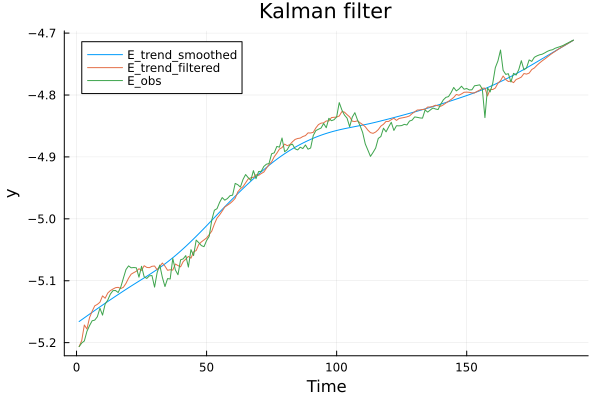


Log likelihood kalman filter: 914.9921377382104


In [5]:
    #Run and print the Kalman filter results
    Log_L_kalman, states_kalman_smooth, _ = diffuse_kalman_filter_alternative(model, y, X, θ_true, α0, P0; do_smooth = true)
    Log_L_kalman, states_kalman_filt, _ = diffuse_kalman_filter_alternative(model, y, X, θ_true, α0, P0; do_smooth=false)
    println("\nLog likelihood kalman filter: ", Log_L_kalman)

    # plot states and data
    plot(states_kalman_smooth[1,:], label="E_trend_smoothed", title="Kalman filter", xlabel="Time", ylabel="y", legend=:topleft)
    plot!(states_kalman_filt[1,:], label="E_trend_filtered")
    plot!(y_filter[1,:], label="E_obs")
    if simulate == true
        plot!(α[1,:], label="E_trend_simulated")
    end
    display(plot!())

## Estimation

In [ ]:
do_MCMC = true
do_MLE = false

## MCMC

In [ ]:
if do_MCMC

    θ_init = zeros(length(θ_elements)) .+ 0.01

    θ_chain_all, θ_chain_init_all, α_draws_all = MCMC_estimation(model, y_est, X_est, prior_info_collection, α0, P0;
        filter_type = "kalman",
        iter_init = 100000, 
        burn_init = 50000,
        iter_rec = 40000,
        burn_rec = 20000,
        ω = 0.01,
        n_chains = n_chains,
        θ_0 = θ_init) # if not θ_0 is given it just draws from prior distributions
    
    println(size(θ_chain_all))
    println(size(α_draws_all))
    
    # MCMC diagnostics
    chain_init = Chains(θ_chain_init_all, θ_elements)
    display(chain_init)
    display(plot(chain_init))
    
    chain_rec = Chains(θ_chain_all, θ_elements)
    display(chain_rec)
    display(plot(chain_rec))
    display(autocorplot(chain_rec))
    
else
    println("Skipping MCMC estimation as do_MCMC is set to false.")
end

## MLE

In [ ]:
if do_MLE

    # choose starting values for MLE
    θ_init = zeros(length(θ_elements)) .+ 0.01
    # θ_init = θ_true
    
    # choose optimizers to run (many options see in MLE file. I just use nelder_mead)
    optimizers = [:nelder_mead]
    
    # Run the MLE estimation
    mle_results = mle_estimation(model, θ_init, y_est, X_est, α0, P0, prior_info, optimizers)
    
    # Extract and print estimated parameters for each method and message
    for (opt, res) in mle_results
        θ_est = Optim.minimizer(res)
        println("Optimizer: $opt, Estimated parameters: ", θ_est)
        println("Optimizer: $opt, Converged: ", Optim.converged(res))
    end
    println("true parameters: ", θ_true)
    
    # Get states for MLE results 
    states_mle_results = Dict{Symbol,Any}()
    for (opt, res) in mle_results
        θ_est = Optim.minimizer(res)
        LogL, states_mle, _ = diffuse_kalman_filter_alternative(model, y_est, X_est, θ_est, α0, P0; do_smooth=true)
        states_mle_results[opt] = states_mle
    end
else
    println("Skipping MLE estimation as do_MLE is set to false.")
    states_mle_results = Dict{Symbol,Any}()  # empty dict if not computed
end

## Visualize estimation results

In [ ]:
# Initialize a vector to store the parameter plots.
plots_vec = []

for i in 1:length(θ_elements)
    p = plot(title = "Parameter $(θ_elements[i])", xlabel = "Value", ylabel = "Density")
    
    # If MCMC was run, plot the posterior density and the corresponding prior for each chain.
    if do_MCMC && θ_chain_all !== nothing
        for j in 1:n_chains
            samples = θ_chain_all[:, i, j]
            density!(p, samples, label = "Posterior (chain $j)", linewidth = 2)
            
            # Define a range for plotting the prior density.
            xs = range(max(minimum(samples) - 0.5, 0.0), maximum(samples) + 0.5, length = 200)
            dist_type = prior_info_collection[j].distributions[i]
            hp1 = prior_info_collection[j].parameters[i, 1]
            hp2 = prior_info_collection[j].parameters[i, 2]
            prior = if dist_type == "uniform"
                Uniform(hp1, hp2)
            elseif dist_type == "beta"
                Beta(hp1, hp2)
            elseif dist_type == "normal"
                Normal(hp1, hp2)
            elseif dist_type == "inverse_gamma"
                InverseGamma(hp1, hp2)
            else
                error("Unknown prior distribution: $dist_type")
            end
            plot!(p, xs, pdf.(prior, xs), label = "Prior (chain $j)", color = :black, linestyle = :dash)
        end
    end
    
    # Add a vertical line for the true parameter value.
    vline!(p, [θ_true[i]], label = "Old $(θ_elements[i])", linestyle = :dashdot, color = :red)
    
    # Overlay MLE estimates from each optimizer if available.
    if do_MLE && mle_results !== nothing
        for (opt, res) in mle_results
            θ_est = (opt == :slsqp) ? res.minimizer : Optim.minimizer(res)
            vline!(p, [θ_est[i]], label = "MLE $(θ_elements[i]) ($opt)", color = :green)
        end
    end
    
    # Append the current plot to the vector.
    push!(plots_vec, p)
end

# Combine all plots into one image and display it.
if !isempty(plots_vec)
    combined_plot = plot(plots_vec..., layout = (length(θ_elements), 1), size = (1000, 300 * length(θ_elements)))
    display(combined_plot)
end




## Plot filtration results for estimation period

In [ ]:
# ----- State Plotting -----
plots_vec = []

α_mean = nothing
α_ci = nothing
# Determine the number of states from the Kalman smoothed states.
n_states = size(states_kalman_smooth, 1)

for i in 1:n_states
    p = plot(title = "State: $(α_elements[i])", xlabel = "Time", ylabel = "Value")
    
    # Overlay MCMC state draws if available.
    if do_MCMC && α_draws_all !== nothing
        n_chains = size(α_draws_all, 4)
        for ch in 1:n_chains
            α_draws = α_draws_all[:, :, :, ch] 
            α_mean = dropdims(mean(α_draws, dims=1), dims=1)
            α_ci = mapslices(x -> quantile(x, [0.025, 0.975]), α_draws, dims=1)
            plot!(p, α_mean[i, :],
                  ribbon = (α_ci[2, i, :] .- α_mean[i, :]),
                  label = "Estimated $(α_elements[i]) (chain $ch)")
        end
    end

    # Overlay MLE state estimates if available.
    if do_MLE && !isempty(states_mle_results)
        for (opt, states_mle) in states_mle_results
            plot!(p, states_mle[i, :], label = "MLE $(α_elements[i]) ($opt)")
        end
    end

    # Overlay the true state if simulation is enabled.
    if simulate
        plot!(p, α[i, :], label = "True state")
    end

    # Overlay observed data (only for the first state).
    if i == 1
        plot!(p, y_est[1, :], label = "E_obs")
    end

    push!(plots_vec, p)
end

if !isempty(plots_vec)
    combined_plot = plot(plots_vec..., layout = (n_states, 1), size = (1000, 300*n_states))
    display(combined_plot)
end

#save image
#savefig(combined_plot, "plots/$(model).png")

## Plot filtration results for filtration period

In [ ]:
N_draws = size(θ_chain_all,1)
#α_filter = Vector{Matrix{Float64}}(undef, N_draws)
T = size(y,2)
α_all_filter = Array{Float64}(undef, n_states, T, N_draws)
for i in 1:N_draws
    θ_i = θ_chain_all[i,:,:]
    _, α_i, _ = diffuse_kalman_filter_alternative(model, y, X, θ_i, α0, P0; do_smooth=true)
    α_all_filter[:,:,i] = α_i 
end

avg   = Array{Float64}(undef, n_states, T)
med   = Array{Float64}(undef, n_states, T)
q2_5  = Array{Float64}(undef, n_states, T)
q97_5 = Array{Float64}(undef, n_states, T)

for n in 1:n_states
    for t in 1:T
        # Get the vector of draws for state n at time t
        samples = α_all_filter[n, t, :]
        # Compute and store the statistics
        avg[n, t]   = mean(samples)
        med[n, t]   = median(samples)
        q2_5[n, t]  = quantile(samples, 0.025)
        q97_5[n, t] = quantile(samples, 0.975)
    end
end


ts = 1:T  # Time vector; replace if you have a different time axis.

plots_vec = []

for i in 1:n_states
    if i == 1
        # For state 1, enable the legend so the extra curve label appears.
        p = plot(ts, med[i, :],
                 ribbon = (med[i, :] - q2_5[i, :], q97_5[i, :] - med[i, :]),
                 title = "State $(α_elements[i])",
                 xlabel = "Time",
                 ylabel = "Value",
                 legend = :bottomleft,
                 label = "Structural")
        # Add the extra curve with a label.
        plot!(p, ts, y[1,:], lw = 2, linestyle = :dash, label = "Observed E")
    else
        # For other states, no legend.
        p = plot(ts, med[i, :],
                 ribbon = (med[i, :] - q2_5[i, :], q97_5[i, :] - med[i, :]),
                 title = "State $(α_elements[i])",
                 xlabel = "Time",
                 ylabel = "Value",
                 legend = false)
    end
    push!(plots_vec, p)
end

combined_plot = plot(plots_vec..., layout = (n_states, 1), size = (1200, 300 * n_states))
display(combined_plot)




## Store as excel file

In [ ]:
gab="TFP"
save_results(y,med,PRBANK,df,gab)